#### Import field data

In [1]:
from initialisation import *

Vs, Ts, FC_star = {}, {}, {}

# Import empirical vegetation density
Vs['grass'] = matrix_to_dict(np.loadtxt('field-data/grassland/vegetation.asc', skiprows=6)[1:-1,1:-1])
Vs['shrub'] = matrix_to_dict(np.loadtxt('field-data/shrubland/vegetation.asc', skiprows=6)[1:-1,1:-1])

# Import empirical topography
Ts['grass'] = matrix_to_dict(np.loadtxt('field-data/grassland/topography.asc', skiprows=6)[1:-1,1:-1])
Ts['shrub'] = matrix_to_dict(np.loadtxt('field-data/shrubland/topography.asc', skiprows=6)[1:-1,1:-1])

# Import MAHLERAN sediment functional connectivity
FC_star['grass'] = matrix_to_dict(np.loadtxt('MAHLERAN-data/grassland/sediment-connectivity.asc', skiprows=6)[1:-1,1:-1])
FC_star['shrub'] = matrix_to_dict(np.loadtxt('MAHLERAN-data/shrubland/sediment-connectivity.asc', skiprows=6)[1:-1,1:-1])


#### Initialise lattice

In [ ]:
# Create baseline 2D lattice, empirical field data default width=20 and height=60
G, bulk_nodes = generate_baseline_lattice(20,60)
S, current, branches, new_active, size = declare_simulation_variables(G)

# Adapt G to shrubland empirical data, assuming probabilistic and deterministic dynamics
G_prob, propagation_probability1, edge_slope1, G_deter, propagation_probability2, edge_slope2 = adapt_lattice_to_topography(G, Ts['shrub'], bulk_nodes)

# Initialise probabilistic dynamics simulation
#
print('Computing node coupling dictionary...')

print('Computing SC...')
SC1 = compute_SC(G_prob, edge_slope1)
SC2 = compute_SC(G_deter, edge_slope2)



Computing node coupling dictionary...
Computing SC...


In [8]:
C1 = create_node_coupling_dictionary(G_prob)
C2 = create_node_coupling_dictionary(G_deter)


#### Visualisation

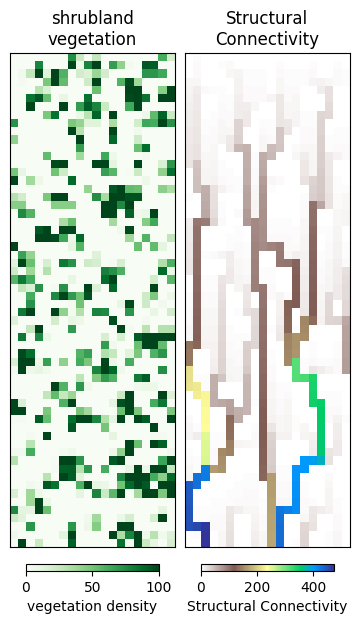

In [5]:
fig, ax = plt.subplots(1,2, figsize=(3.5,6), constrained_layout=True)
p = ax[0].imshow(dict_to_mat(Vs['shrub']), cmap='Greens'), ax[1].imshow(dict_to_mat(SC2), cmap='terrain_r')
_ = [ax[k].set_xticks([]) for k in range(2)]
_ = [ax[k].set_yticks([]) for k in range(2)]
cbar = [fig.colorbar(p[k], ax=ax[k], orientation='horizontal', shrink=.8, pad=.03) for k in range(2)]
_ = ax[0].set_title('shrubland\nvegetation')
_ = ax[1].set_title('Structural\nConnectivity')
cbar[0].set_label('vegetation density')
cbar[1].set_label('Structural Connectivity')
plt.show()

#### Simulation run

In [ ]:
# Select nb_runs (number of simulations), nb_steps (number of steps per simulation) and step_slice (number of steps between two FC measurements).
# default suggested values: (nb_steps, step_slice) = (10000, 200) for deterministic dynamics; and (50000, 1000) for probabilistic dynamics.
nb_runs, nb_steps, step_slice = 1, 50000, 2000
SC_FCt, FC_FCt, FCs, Sizes = np.zeros((nb_runs, int(nb_steps/step_slice)), float), np.zeros((nb_runs, int(nb_steps/step_slice)), float), np.zeros(nb_runs, dict), np.zeros(nb_runs, list)

for run in range(nb_runs):
    print('Run n°'+str(run+1)+'...')
    # Reset simulation variables, empty the node coupling tracker C and create FC dict
    S, current_av, branches, active, Sizes[run] = declare_simulation_variables(G)
    C_run = {i:{} for i in C2}
    for i in C2:
        for j in C2[i]:
            C_run[i][j] = []
    for step in range(nb_steps+1):
        S, C_run, current_av, branches, active, Sizes[run] = sandpile(G_deter, Vs['shrub'], propagation_probability2, S, C_run, current_av, branches, active, Sizes[run], bulk_nodes)
        if step % step_slice == 0 and step>0:
            FC = compute_FC2(C_run)
            SC_FCt[run, int(step/step_slice-1)], FC_FCt[run, int(step/step_slice-1)] = SCFC(SC2,FC,bulk_nodes), SCFC(FC_star['shrub'],FC,bulk_nodes)
            print(round(SC_FCt[run, int(step/step_slice-1)],2))
    FCs[run] = FC

print('After '+str(nb_runs)+' runs of '+str(nb_steps)+' steps,')
print('Average SC-FC correlation: '+str(round(np.mean([SC_FCt[run,-1] for run in range(nb_runs)]),2)))


Run n°1...
-0.01
-0.01
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
-0.02
After 1 runs of 50000 steps,
Average SC-FC correlation: -0.02


In [13]:
print(C_run)
print(compute_FC2(C_run))

{(0, 0): {}, (0, 1): {(1, 1): [], (2, 1): [], (2, 0): []}, (0, 2): {(1, 2): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (2, 2): [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], (2, 1): [], (2, 0): []}, (0, 3): {(0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 4): {(1, 4): [], (0, 3): [], (1, 3): [], (2, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 5): {(0, 4): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (1, 4): [], (0, 3): [], (1, 3): [], (2, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 6): {(0, 5): [], (0, 4): [], (1, 4): [], (0, 3): [], (1, 3): [], (2, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 7): {(0, 6): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
def sandpile(g, v, ep, state, coupling, current_av, branches, old_active, size, not_sinks):# exit_,
    new_active, unstable = [], [node for node in old_active if state[node] >= g.out_degree(node)]
    if len(unstable):
        for node1 in unstable:
            nb_partcl, state[node1] = state[node1], 0
            if len(current_av) == 0:
                current_av[node1] = 0
            if g.out_degree(node1):
                spreading_scheme = Counter(random.choices(list(g.successors(node1)), weights=ep[(node1)], k=nb_partcl))
                for node2 in spreading_scheme:
                    state[node2] += np.sum(np.random.rand(spreading_scheme[node2]) > v[node2]/2)
                    current_av[node2] = current_av[node1]+1
                    if node2 not in branches:
                        branches[node2] = [node1]
                    elif node1 not in branches[node2]:
                        branches[node2].append(node1)
                    # record all the previous sources of the new incident node (at least, from a new path)
                    origin, all_sources, sources = list(current_av.keys())[0], [node1], [node1]
                    while origin not in sources:
                        new_sources = []
                        for source in sources:
                            new_sources += branches[source]
                        new_sources = list(set(new_sources))
                        all_sources += new_sources
                        sources = new_sources
                    # record couplings between new incident node and all its previous sources
                    for source in all_sources: # collapse 'all_sources' to avoid redundance of nodes
                        coupling[source][node2].append(current_av[node2]-current_av[source])
                    if node2 not in new_active:
                        new_active.append(node2)
            #else:
            #    exit_ += nb_partcl
    else:
        if len(current_av):
            size.append(len(current_av)-1)
        current_av, branches = {}, {}
        node2 = random.choice(not_sinks)
        #print(node2, v[node2], type(node2), type(v[node2]))
        #if v[node2] == 0:
        if random.random() > v[node2]/2:
            state[node2] += 1
            new_active.append(node2)
    return state, coupling, current_av, branches, new_active, size#, exit_




{(0, 0): 0, (0, 1): 0, (0, 2): 0.25, (0, 3): 0, (0, 4): 0, (0, 5): 0.0, (0, 6): 0, (0, 7): 0.0, (0, 8): 1.1388888888888888, (0, 9): 1.551020408163265, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0.1875, (0, 14): 0.609375, (0, 15): 0, (0, 16): 0, (0, 17): 0, (0, 18): 0.6666666666666666, (0, 19): 0, (0, 20): 0, (0, 21): 0, (0, 22): 0, (0, 23): 0.0, (0, 24): 0.25, (0, 25): 0.6666666666666666, (0, 26): 0, (0, 27): 0, (0, 28): 0.0, (0, 29): 0.0, (0, 30): 0, (0, 31): 0, (0, 32): 0, (0, 33): 0, (0, 34): 0, (0, 35): 0, (0, 36): 0, (0, 37): 0, (0, 38): 1.3599999999999999, (0, 39): 1.8055555555555554, (0, 40): 0.0, (0, 41): 0, (0, 42): 0, (0, 43): 0.2222222222222222, (0, 44): 0, (0, 45): 0, (0, 46): 0, (0, 47): 0, (0, 48): 0, (0, 49): 0, (0, 50): 0.0, (0, 51): 0, (0, 52): 7.734375, (0, 53): 9.3, (0, 54): 0.6666666666666666, (0, 55): 0, (0, 56): 0, (0, 57): 0, (0, 58): 0, (0, 59): 0, (1, 0): 0, (1, 1): 0.0, (1, 2): 0.0, (1, 3): 0, (1, 4): 0, (1, 5): 0.2222222222222222, (1, 6): 0.0, (1, 7): 0.25,

NameError: name 'SC' is not defined

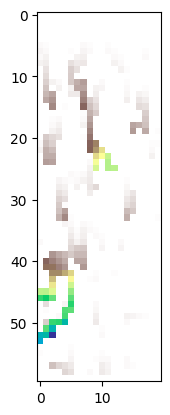

In [11]:
def compute_FC(coupling):
    '''
    Compute FC
    Input
        coupling: tracked particle exchange (list of integers) between a
    '''
    fc = {i:0 for i in coupling}
    for i in coupling:
        fci = sum(coupling[i].values(),[])
        if len(fci):
            fc[i] += np.var(fci)
        else:
            fc[i] = 0
    return fc

def compute_FC2(c):
    fci, fc = {i:[] for i in c}, {}
    for i in c:
        for j in c[i]:
            fci[j] += c[i][j]
    for i in c:
        fc[i] = 0
        if len(fci[i]):
            fc[i] = np.var(fci[i])
    return fc

FC = compute_FC(C_run)
print(FC)
FC2 = compute_FC2(C_run)
print(FC2)
plt.imshow(dict_to_mat(FC2), cmap='terrain_r')
print(SCFC(SC,FC,bulk_nodes))
print(SCFC(SC,FC2,bulk_nodes))



#### Visualisation

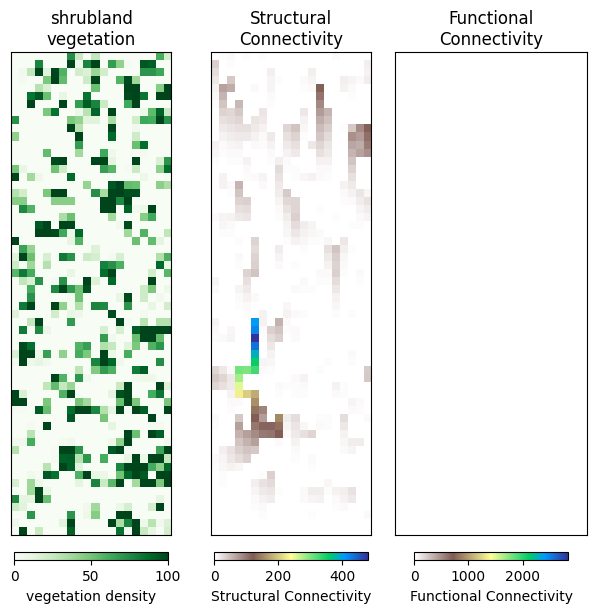

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(6,6), constrained_layout=True)
p = ax[0].imshow(dict_to_mat(Vs['shrub']), cmap='Greens'), ax[1].imshow(dict_to_mat(SC), cmap='terrain_r'), ax[2].imshow(dict_to_mat(FCs[run]), cmap='terrain_r')
_ = [ax[k].set_xticks([]) for k in range(3)]
_ = [ax[k].set_yticks([]) for k in range(3)]
cbar = [fig.colorbar(p[k], ax=ax[k], orientation='horizontal', shrink=.8, pad=.03) for k in range(3)]
_ = ax[0].set_title('shrubland\nvegetation')
_ = ax[1].set_title('Structural\nConnectivity')
_ = ax[2].set_title('Functional\nConnectivity')
cbar[0].set_label('vegetation density')
cbar[1].set_label('Structural Connectivity')
cbar[2].set_label('Functional Connectivity')
plt.show()

In [9]:
print(C_run)

{(0, 0): {}, (0, 1): {(1, 1): [], (2, 1): [], (2, 0): []}, (0, 2): {(1, 2): [1], (2, 2): [2], (2, 1): [], (2, 0): []}, (0, 3): {(0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 4): {(0, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 5): {(0, 4): [1, 1, 1, 1, 1, 1, 1, 1, 1], (0, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 6): {(0, 5): [], (0, 4): [], (0, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 7): {(0, 6): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (0, 5): [], (0, 4): [], (0, 3): [], (0, 2): [], (1, 2): [], (2, 2): [], (2, 1): [], (2, 0): []}, (0, 8): {(0, 7): [1, 1], (0, 6): [2, 2],

#### Avalanche size analysis